<a href="https://colab.research.google.com/github/IsmaelBeviaB/CounterfactualesTFM_IBB/blob/main/CounterfactualesTFM_IBB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 3.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import numpy as np
import math
import shap
from scipy.stats import chi2_contingency
from sklearn.metrics.pairwise import euclidean_distances
import random
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import mode
import networkx as nx
from scipy.spatial.distance import pdist, squareform
import heapq
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Propuesta 1. Formulación de contrafactuales

In [ ]:
 def gower_precentile(X):
  """
  Cálculo de los rangos intercuartílicos (IQR) para la normalización posterior de las muestras.
  Args:
    X: Una matriz bidimensional donde cada columna representa una variable y cada fila una muestra.
  Return:
    ranges: Una lista de los rangos especificos calculados sobre cada caracteristica.
  """
  ranges=[]
  percentiles_base = [(80, 20),(85,15), (90, 10), (95, 5)]
  percentiles_exception= [(95.1 + i * 0.1, 4.9 - i * 0.1) for i in range(0, 50)]
  percentiles=percentiles_base+percentiles_exception

  for z,column in enumerate(X.T):
    elementos_unicos = set(column)
    if elementos_unicos == {0, 1}:
      rang = 1
    else:
      for p_high, p_low in percentiles:
        rang = np.percentile(column, p_high) - np.percentile(column, p_low)
        if rang != 0:
          break
      if rang == 0:
        rang=1
    ranges.append(rang)
  return ranges

def transform_data(X, rangos_normalizacion):
    """
    Normalización de las muestras en la matriz X utilizando los rangos dados.
    Args:
      X: Una matriz bidimensional donde cada columna representa una variable y cada fila una muestra.
      rangos_normalizacion: Una lista de los rangos de normalización correspondientes a cada característica en X.
    Returns:
      np.array(X_norm): Una matriz bidimensional de muestras normalizadas.
    """
    X_norm = X.copy()
    X_norm /= rangos_normalizacion
    return np.array(X_norm)

def distance(muestra1, muestra2, weights):
    """
    Cálculo de la distancia euclidiana ponderada entre dos muestras.
    Args:
      muestra1: La primera muestra a considerar.
      muestra2: La segunda muestra a considerar.
      weights: Los pesos utilizados para ponderar cada dimensión en el cálculo de la distancia.
    Returns:
      euclidean_dist: La distancia euclidiana ponderada entre las dos muestras.
    """
    dif_norm=(muestra1 - muestra2)
    euclidean_dist = np.sqrt(np.sum(np.multiply((dif_norm),weights.flatten())**2))
    return euclidean_dist

def shap_instace(X, instancia, model, posiciones_casos_etiqueta_objetivo):
  """
  Cálculo de los valores SHAP para una instancia dada a partir del modelo indicado y un conjunto de datos de fondo formado por 1000 muestras pertenecientes a la clase objetivo.
  Args:
    X: El conjunto de datos como una matriz bidimensional.
    instancia: La instancia sometida a estudio para la cual se calcularán los valores SHAP.
    model: El modelo predictivo utilizado para generar los valores SHAP.
    posiciones_casos_etiqueta_objetivo: Las posiciones de las muestras en el conjunto de datos utilizadas como fondo para el cálculo de SHAP.
  Returns:
    shap_values_instancia: Los valores SHAP para la instancia dada.
  """
  Fondo_Shap=X[posiciones_casos_etiqueta_objetivo]
  explainer = shap.KernelExplainer(model, Fondo_Shap[:1000])
  shap_values_instancia  = explainer.shap_values(instancia.reshape(1, -1))
  shap_values_abs = [[abs(numero) for numero in sublista] for sublista in shap_values_instancia]
  return shap_values_instancia

def dummies(posiciones_mas_altas, caracteristicas_columnas_dummies):
  """
  Indentificación de las posiciones de las características dummy ligadas con las características seleccionadas por su importancia para formar el contrafactual.
  Args:
    posiciones_mas_altas: Una lista de las posiciones de las características seleccionadas según su importancia para formar el contrafactual.
    caracteristicas_columnas_dummies: Un diccionario donde las claves son nombres de características y los valores son listas de posiciones de columnas dummy asociadas.
  Returns:
    posiciones_causales_dummies: Una lista de las posiciones de las características dummy relacionadas con las características más importantes.
  """
  resultados = []
  for val in posiciones_mas_altas:
    for sublist in caracteristicas_columnas_dummies.values():
      if val in sublist:
        resultados.extend(sublist)
        break
  posiciones_causales = list(set(resultados))
  posiciones_causales_dummies = [valor for valor in posiciones_causales if valor not in posiciones_mas_altas]
  return posiciones_causales_dummies

def chi2(posiciones_no_modificables, posiciones_mas_altas, X, variables_categoricas,grupos_dummy,causales_dummy):
  """
  Identificación de características categóricas relacionadas con las características seleccionadas para formar el contrafactual mediante la prueba de independencia chi-cuadrado.
  Args:
    posiciones_no_modificables: Una lista de las posiciones de características que no deben ser modificadas indicadas por parametro.
    posiciones_mas_altas: Una lista de las posiciones de las características seleccionadas según su importancia para formar el contrafactual.
    X: El conjunto de datos como una matriz bidimensional.
    variables_categoricas: Una lista de posiciones de las características categóricas en X.
    grupos_dummy: Un diccionario donde las claves son nombres de características y los valores son listas de posiciones de columnas dummy asociadas.
    causales_dummy: Una lista de posiciones de características dummy relacionadas con las características de las posiciones_mas_altas.
  Returns:
    posiciones_causales_chi2: Una lista de posiciones de características identificadas como relevantes mediante la prueba chi-cuadrado.
    restriciones_causales: Un diccionario que asigna posiciones de características más importantes a posiciones de características relevantes identificadas.
  """
  posiciones_no_causales=posiciones_no_modificables + posiciones_mas_altas + causales_dummy
  posibles_posiciones_causales = list(range(0, (X.shape[1])))
  caracteristicas_causalidad = [numero for numero in posibles_posiciones_causales if numero not in posiciones_no_causales]
  caracteristicas_causalidad_categoricas = [x for x in caracteristicas_causalidad if x in variables_categoricas]
  restricciones={}
  posiciones_causales=[]
  posiciones_causales_total=[]
  restriciones_causales={}
  for caracteristica_importante in posiciones_mas_altas:
    if len(set(X_scaled[:1000,caracteristica_importante]))>len(X_scaled[:1000,caracteristica_importante])*0.95:
      continue
    ipos = 0
    posiciones_causales=[]
    while ipos < len(caracteristicas_causalidad_categoricas):
        caracteristica_causal = caracteristicas_causalidad_categoricas[ipos]
        dummy=False
        caracteristica_compare=X[:1000,caracteristica_causal]
        for grupo, caracteristicas in grupos_dummy.items():
          if caracteristica_causal in caracteristicas:
            caracteristica_compare = np.where(np.all(X[:1000,caracteristicas] == 0, axis=1), 0, np.argmax(X[:1000,caracteristicas], axis=1)+1)
            ipos += len(caracteristicas)-1
            caracteristica_causal=caracteristicas
            dummy=True
            break
        tabla_de_frecuencia = pd.crosstab(X[:1000,caracteristica_importante], caracteristica_compare)
        chi2, _, _, _ = chi2_contingency(tabla_de_frecuencia)
        n = tabla_de_frecuencia.sum().sum()
        coef_contingencia = np.sqrt(chi2 / (n * min(tabla_de_frecuencia.shape) - 1))
        ipos += 1
        if coef_contingencia > 0.8:
          if dummy==True:
            posiciones_causales = posiciones_causales + caracteristica_causal
          else:
            posiciones_causales.append(caracteristica_causal)
    posiciones_causales_total=posiciones_causales_total+posiciones_causales
    if posiciones_causales!=[]:
      restriciones_causales[caracteristica_importante]=posiciones_causales
  posiciones_causales_chi2=list(set(posiciones_causales_total))
  return posiciones_causales_chi2,restriciones_causales

def restricciones(X,colum_names,target_name,restriccion_variables_categoricas):
  """
  Construcción de las restricciones que se van a utilizar en la optimización sobre todas las características del conjunto de datos. Incluyen los valores máximos y mínimos, y para las categóricas,
  una lista de valores únicos disponibles.
  Args:
    X: El conjunto de datos como una matriz bidimensional.
    column_names: Una lista de nombres de columnas del conjunto de datos.
    target_name: El nombre de la columna que representa la variable objetivo.
    restriccion_variables_categoricas: Una lista de nombres de las columnas correspondientes a las variables categóricas.
  Returns:
    list: Una lista de tuplas, donde cada tupla incluye:
      categorical: Un indicador de si la característica es categórica o no.
      val_posibles: Un conjunto de valores posibles para la característica (solo si es categórica).
      min_val: El valor mínimo observado para la característica.
      max_val: El valor máximo observado para la característica.
  """
  restricciones = []
  pos_X_train=0
  for columna in columns_name:
      categorical=False
      val_posibles=None
      if columna != target_name:
        for restriccion in restriccion_variables_categoricas:
          if columna.startswith(restriccion+'_') or columna==restriccion:
            categorical=True
            val_posibles=set(X[:,pos_X_train])
        restricciones.append((categorical,val_posibles,X[:,pos_X_train].min(),X[:,pos_X_train].max()))
        pos_X_train=pos_X_train+1
      else:
        pos_X_train=pos_X_train+1
  return restricciones

def density_group(density_test,counterfactual, model_density,min_density,n_neighbors):
  """
  Comprobación de si un contrafactual cumple con el mínimo de densidad utilizando un modelo de densidad y un umbral establecido.
  Args:
    density_test: El tipo de prueba de densidad a utilizar. Puede ser "lof", "nbrs" o "nbrs_mean".
    counterfactual: Un array que representa el contrafactual a evaluar.
    model_density: El modelo de densidad entrenado que se utilizará para la evaluación.
    min_density: El valor mínimo de densidad requerido para que una muestra sea considerada válido.
    n_neighbors: El número de vecinos que se ha decidido considerar por párametro en los métodos basados en vecinos.
  Returns:
    bool: True si el contrafactual cumple con el criterio de densidad, False en caso contrario.
  """
  if density_test=="lof":
    dense=model_density.predict([counterfactual])
    if dense==1:
      return True
    return False
  elif density_test=="nbrs" or density_test=="nbrs_mean":
    distancias_nueva, _ = model_density.kneighbors([counterfactual])
    if density_test=="nbrs":
      distancia_k = distancias_nueva[0][n_neighbors-1]
      densidad_muestra = 1.0 / (distancia_k + 1e-6)
    else:
      densidad_muestra = 1.0 / (np.mean(distancias_nueva[:,1:], axis=1) + 1e-6)
    return densidad_muestra >= min_density

def make_prediction(model,case_study,multiclass):
  """
  Predicción sobre la muestra utilizando el modelo de clasificación indicado por el usuario.
  Args:
    model: El modelo entrenado que se utilizará para la predicción.
    case_study: Un array que representa la muestra para la cual se realizará la predicción.
    multiclass: Un indicador de si el modelo es para un problema multiclase o binario.
  Returns:
    prediction: La clase predicha para el caso de estudio.
  """
  if multiclass:
    prediction=np.argmax(model.predict(case_study.reshape(1, -1)))
  else:
    prediction = round(model.predict(case_study.reshape(1, -1))[0][0])
  return prediction

def max_decimales_por_variable(array):
    """
    Cálculo del número máximo de decimales presentes en cada columna de una matriz para garantizar que el contrafactual final presente la misma estructura que
    los casos del conjunto de datos.
    Args:
      array: Una matriz bidimensional donde cada columna representa una variable y cada fila una muestra.
    Returns:
      max_decimales: Una lista que contiene el número máximo de decimales para cada columna de la matriz.
    """
    max_decimales = []
    for columna in array.T:
        max_decimales.append(max([len(str(x).split('.')[-1]) for x in columna]))
    return max_decimales

def ajustar_decimales(muestra, max_decimales_por_variable):
  """
  Ajuste sobre cada valor de los decimales del contrafactual final de acuerdo con el máximo número calculado en la función anterior.
  Args:
    muestra: Muestra sobre la que ajustar las características.
    max_decimales_por_variable: Lista del máximo número de decimales permitidos para cada variable.
  Returns:
    muestra: Lista de valores con los decimales ajustados según las restricciones especificadas.
  """
  for i_valor,valor in enumerate(muestra):
    decimales_actuales = len(str(valor).split('.')[-1])
    if decimales_actuales > max_decimales_por_variable[i_valor]:
      muestra[i_valor] = round(valor, max_decimales_por_variable[i_valor])
  return muestra

def test_final_disp(optimized_counterfactual,instance,pos_opt_final,counterfactuals,model,multiclass,rangos_normalizacion,model_density,min_density,n_neighbors):
  """
  Evaluación final sobre un contrafactual optimizado para asegurar su dispesión con el resto de los ya formados.
  Args:
    optimized_counterfactual: El contrafactual optimizado que se va a evaluar.
    instance: La instancia original de la cual se deriva el contrafactual.
    pos_opt_final: Lista de posiciones finales optimizadas.
    counterfactuals: Lista de contrafactuales previamente generados.
    model: El modelo predictivo introducido por el usuario.
    multiclass: Indicador si el problema es de clasificación multiclase.
    rangos_normalizacion: Los rangos de normalización utilizados para escalar los datos.
    model_density: El modelo utilizado para evaluar la densidad de las muestras.
    min_density: La densidad mínima requerida para que un contrafactual sea considerado válido.
    n_neighbors: El número de vecinos que se ha decidido considerar por párametro en los métodos basados en vecinos.
  Returns:
    bool: True si el contrafactual final ajustado es válido, False en caso contrario.
  """
  compare_ubi=[]
  for ct in np.array(counterfactuals.copy()):
    diferencia_ct = np.subtract(instance,ct)
    ubicaciones_diferentes_ct = np.where(diferencia_ct != 0)
    compare_ubi.append(ubicaciones_diferentes_ct)
  test_counterfactual_final = optimized_counterfactual.copy()
  for i in pos_opt_final:
    test_counterfactual = optimized_counterfactual.copy()
    test_counterfactual[i] = instance[i]
    prediction=make_prediction(model,test_counterfactual,multiclass)
    dens=density_group(density_test,transform_data(test_counterfactual.reshape(1, -1).copy(),rangos_normalizacion)[0], model_density,min_density,n_neighbors)
    if prediction==target and dens==True:
      test_counterfactual_final[i]=instance[i]
  diferencia_ct = np.subtract(instance,test_counterfactual_final)
  ubicaciones_diferentes_ct = np.where(diferencia_ct != 0)
  if compare_ubi:
    for ubi_anterior in compare_ubi:
      if np.array_equal(ubi_anterior, ubicaciones_diferentes_ct):
        return False
  return True

def gradient_counterfactual(muestra1, muestra2, weights,rangos_normalizacion):
    """
    Cálculo del gradiente necesario para ajustar una muestra contrafactual en dirección al caso original.
    Args:
      muestra1: La muestra original.
      muestra2: La muestra contrafactual la cual queremos ajustar.
      weights: Los pesos que indican la importancia de cada característica.
      rangos_normalizacion: Los rangos de normalización para cada característica.
    Returns:
      gradiente: El gradiente calculado para ajustar el contrafactual hacia la instancia original.
    """
    array_rangos_normalizacion = np.array(rangos_normalizacion)
    diff_weight=weights**2 *(muestra2-muestra1)
    denominador=array_rangos_normalizacion**2 * np.sqrt(((muestra1-muestra2)**2 / array_rangos_normalizacion**2 * weights**2))
    gradiente=diff_weight/(denominador+1e-16)
    return gradiente

def gradient_descent(instancia_original, counterfactual_inicial, target, multiclass, model, weights, all_weights_shap, rangos_normalizacion,restricciones,dic_restricion_chi2, model_density,density_test, min_density,n_neighbors,inicial_learning_rate=0.1, factor_decay_learning=0.1, minimal_learning_rate=0.0001, iterations=1000):
  """
  Aplicación del método de descenso de gradiente para encontrar un contrafactual óptimo sobre la función objetivo anterior. A medida que se modifica la muestra se realizan una serie de ajustes
  en base a restricciones básicas construidas previamente y se asegura en todo momento que se trata de un contrafactual válido, con densidad adecuada y una distancia menor a la iteración anterior.
  Se busca optimizar todas las características hasta su valor posible más cercano a los de la instancia original.
  Args:
    instancia_original: La muestra original a partir de la cual se quiere generar el contrafactual.
    counterfactual_inicial: El contrafactual inicial.
    target: La clase objetivo que se desea alcanzar con el contrafactual.
    multiclass: Indica si el modelo es para un problema de clasificación multiclase.
    model: El modelo predictivo utilizado.
    weights: Los pesos para cada característica en el cálculo del gradiente.
    all_weights_shap: Pesos adicionales basados en valores SHAP.
    rangos_normalizacion: Los rangos de normalización para cada característica.
    restricciones: Lista de restricciones para las características.
    dic_restricion_chi2: Diccionario de restricciones basadas en el test chi-cuadrado.
    model_density: Modelo para evaluar la densidad.
    density_test: Datos de prueba para la densidad.
    min_density: Densidad mínima requerida.
    n_neighbors: Número de vecinos para evaluar la densidad.
    inicial_learning_rate: Tasa de aprendizaje inicial.
    factor_decay_learning: Factor de decaimiento para la tasa de aprendizaje.
    minimal_learning_rate: Tasa de aprendizaje mínima.
    iterations: Número de iteraciones máximas.
  Returns:
    counterfactual: El contrafactual optimizado.
  """
  counterfactual=counterfactual_inicial.copy()
  possible_counterfactual = counterfactual_inicial.copy()
  postpreprocesed_counterfactual=counterfactual_inicial.copy()
  learning_rate=inicial_learning_rate
  instancia_original_norm=transform_data(instancia_original.reshape(1, -1).copy(),rangos_normalizacion)
  distance_new=distance(transform_data(possible_counterfactual.reshape(1, -1).copy(),rangos_normalizacion),instancia_original_norm,all_weights_shap)+1
  weights=weights
  grad_weights=weights.copy()
  if all(elemento == 0 for elemento in weights):
    return counterfactual
  for i in range(iterations):
      last_possible_counterfactual=possible_counterfactual.copy()
      distance_pre=distance_new
      gradiente = gradient_counterfactual(instancia_original, possible_counterfactual, grad_weights,rangos_normalizacion)
      gradiente = np.nan_to_num(gradiente)
      possible_counterfactual -= learning_rate * gradiente
      distance_new=distance(transform_data(possible_counterfactual.reshape(1, -1).copy(),rangos_normalizacion),instancia_original_norm, all_weights_shap)
      for j, (categorical,val_posibles, min_val, max_val) in enumerate(restricciones):
        if categorical:
          valor_actual = possible_counterfactual[j]
          if not valor_actual in val_posibles:
            postpreprocesed_counterfactual[j] = min(val_posibles, key=lambda x: abs(x - valor_actual))
        else:
          valor_actual=possible_counterfactual[j]
          postpreprocesed_counterfactual[j] = max(min(valor_actual, max_val), min_val)
      for clave, valores in dic_restricion_chi2.items():
        valor_ref=postpreprocesed_counterfactual[clave]
        claves_numericas = [k for k in valores.keys() if isinstance(k, (int, float))]
        clave_mas_aproximada = min(claves_numericas, key=lambda x: abs(x - valor_ref))
        postpreprocesed_counterfactual[valores['posiciones']]=valores[clave_mas_aproximada]
        possible_counterfactual[valores['posiciones']]=valores[clave_mas_aproximada]
      prediction=make_prediction(model,postpreprocesed_counterfactual,multiclass)
      if prediction != target or density_group(density_test,transform_data(postpreprocesed_counterfactual.reshape(1, -1).copy(),rangos_normalizacion)[0], model_density,min_density,n_neighbors)==False or density_group(density_test,transform_data(possible_counterfactual.reshape(1, -1).copy()[0],rangos_normalizacion), model_density,min_density,n_neighbors)==False or distance_new > distance_pre or np.all(grad_weights == 0):
          if not np.all(grad_weights == 0):
            indice_max = np.argmax(grad_weights)
            grad_weights[indice_max] = 0
            distance_new=distance_new+1
            possible_counterfactual=(last_possible_counterfactual)
          else:
            learning_rate = learning_rate * factor_decay_learning
            grad_weights=weights.copy() #
            possible_counterfactual=(last_possible_counterfactual)
            distance_new=distance_new+1
            if learning_rate < minimal_learning_rate:
              break
      else:
        counterfactual=postpreprocesed_counterfactual.copy()
  return counterfactual

In [ ]:
def createCounterfactual(data, instance, target,target_name, multiclass, model, density_test="lof", n_neighbors=50, density_threshold=None, num_counterfactuals=3, max_modificable_feature=10, inicial_learning_rate=0.1, factor_decay_learning=0.1, minimal_learning_rate=0.00001, iterations=1000, restriccion_categorias_no_modificables=[], restriccion_variables_categoricas=[],max_sustitute_text=500):
  """
  Función principal que debe llamar un usuario para formar los contrafactuales utilizando el método propuesto.
  Args:
    data: Conjunto de datos en formato DataFrame.
    instance: Muestra original para la cual se desea generar el contrafactual sin la categoría objetivo.
    target: Clase objetivo que se desea alcanzar con el contrafactual.
    target_name: Nombre de la variable objetivo.
    multiclass: Indica si el modelo es para un problema de clasificación multiclase.
    model: Modelo predictivo utilizado sobre el que realizar las predicciones.
    density_test: El tipo de prueba de densidad a utilizar. Puede ser "lof", "nbrs" o "nbrs_mean" (por defecto "lof").
    n_neighbors: Número de vecinos para evaluar la densidad (por defecto 50).
    density_threshold: Umbral de densidad mínima como un valor de 0 a 1 siendo uno el valor máximo observado en el conjunto (prescindible al emplear "lof").
    num_counterfactuals: Número de contrafactuales a generar para un caso de estudio (por defecto 3).
    max_modificable_feature: Máximo número de características modificables (por defecto 10).
    inicial_learning_rate: Tasa de aprendizaje inicial en el algoritmo de optimización (por defecto 0.1).
    factor_decay_learning: Factor de decaimiento para la tasa de aprendizaje (por defecto 0.1).
    minimal_learning_rate: Tasa de aprendizaje mínima (por defecto 0.00001).
    iterations: Número de iteraciones máximas en el algoritmo de optimización (por defecto 1000).
    restriccion_categorias_no_modificables: Restricciones de categorías no modificables (opcional).
    restriccion_variables_categoricas: Restricciones de variables categóricas (opcional).
    max_sustitute_text: Máximo número de pruebas por sustituciones de características en la predicción (por defecto 500).
  Returns:
    counterfactuals: Contrafactuales generados.
  """
  # Preparado de los datos
  y=data[target_name]
  data.drop([target_name], axis=1, inplace=True)
  X=data
  columns_name=data.columns
  counterfactuals = pd.DataFrame()
  counterfactuals = pd.DataFrame(columns=data.columns)
  X = np.array(X)
  y = np.array(y)

  # Determinación de la cantidad máxima de decimales por variable
  conjunto_decimales=max_decimales_por_variable(X)

  # Normalización de los datos y la instancia original
  rangos_normalizacion = gower_precentile(X)
  X_norm=transform_data(X.copy(),rangos_normalizacion)
  instance_norm=transform_data(instance.reshape(1, -1).copy(),rangos_normalizacion)

  # Construcción del modelo para estimar la densidad utilizando el método especificado
  if density_test=="lof":
    model_density = LocalOutlierFactor(n_neighbors=n_neighbors,novelty=True)
    model_density.fit(X_norm[y==target])
    min_density = None
  elif density_test=="nbrs" or density_test=="nbrs_mean":
    if density_threshold==None:
       print("Se necesita un umbral para nbrs")
       return
    model_density = NearestNeighbors(n_neighbors=n_neighbors)
    model_density.fit(X_norm[y==target])
    distances, _ = model_density.kneighbors(X_norm[y==target])
    if density_test=="nbrs_mean":
      density = 1.0 / (np.mean(distances[:,1:], axis=1) + 1e-6)
    else:
      density = 1.0 / (distances[:,n_neighbors-1] + 1e-6)
    min_density = np.percentile(density, density_threshold*100)
  else:
    print("Técnica de prueba de densidad incorrecta. Opciones: lof, nbrs, nbrs_mean")
    return

  # Identificación de las posiciones de los casos con la etiqueta objetivo
  posiciones_casos_etiqueta_objetivo=[]
  for i, valor in enumerate(y):
    if valor == target:
      posiciones_casos_etiqueta_objetivo.append(i)

  # Cálculo de los valores SHAP para la instancia original
  shap_values_instancia=shap_instace(X, instance, model, posiciones_casos_etiqueta_objetivo)

  # Identificación de las posiciones de características no modificables, categóricas y dummies
  posiciones_no_modificables = [c for c, columna in enumerate(columns_name) if any(columna.startswith(restriccion+'_') or columna == restriccion for restriccion in restriccion_categorias_no_modificables)]
  posiciones_variables_categoricas=[]
  columnas_dummies=[]
  caracteristicas_columnas_dummies = {restriccion: [] for restriccion in restriccion_variables_categoricas}
  for i, columna in enumerate(columns_name):
    for restriccion in restriccion_variables_categoricas:
      if columna.startswith(restriccion+'_') or columna==restriccion:
        posiciones_variables_categoricas.append(i)
        if columna.startswith(restriccion+"_"):
          caracteristicas_columnas_dummies[restriccion].append(i)

  # Desarrollo del vector de pesos SHAP y de una lista ordenada con las variables de mayor contribución
  if multiclass==True:
    shap_elements = [sublist[target] for sublist in shap_values_instancia[0]]
    weights_shap=np.abs(shap_elements)
    valores_con_indices = list(enumerate(abs(np.array(shap_elements))))
  else:
    weights_shap=np.abs(shap_values_instancia[0])
    valores_con_indices = list(enumerate(abs(shap_values_instancia[0])))
  valores_con_indices.sort(key=lambda x: x[1], reverse=True)
  valores_con_indices_filtrados = [(indice, valor) for indice, valor in valores_con_indices if indice not in posiciones_no_modificables]

  # Cálculo inicial de las distancias para encontrar los casos de la clase opuesta más similares
  distancias = []
  for posicion in posiciones_casos_etiqueta_objetivo:
    distancia=distance(instance_norm[0], X_norm[posicion], weights_shap)
    distancias.append((posicion, distancia))
  distancias_ordenadas = sorted(distancias, key=lambda x: x[1])
  posiciones_ordenadas = [posicion for posicion, _ in distancias_ordenadas]

  # Bucle para generar los distintos contrafactuales
  num_count=1
  modificable_feature=0
  non_modificable_feature=[]
  posiciones_causales_combinadas=[]
  counterfactual_diferences=[]
  imposible_counterfactual=False
  while num_count <= num_counterfactuals:
    good_counterfactual=False
    while good_counterfactual==False:
      # Comprobación sobre si se ha agotado el número de características modificables o si es imposible generar más contrafactuales
      if len(non_modificable_feature) == max_modificable_feature or imposible_counterfactual==True:
        print("No se ha encontrado más contrafactuales reales con las restricciones indicadas.")
        return counterfactuals
      modificable_feature=modificable_feature+1
      substitute_test=0
      # Modificación lógica y secuencial del número de características modificables al formar un nuevo contrafactual dentro de los límites permitidos
      while modificable_feature==0 or modificable_feature in non_modificable_feature or modificable_feature > max_modificable_feature:
        if modificable_feature > max_modificable_feature:
          modificable_feature=1
        else:
          modificable_feature=modificable_feature+1
      # Conclusión sobre las posiciones de las características más influyentes que han sido seleccionadas para ser modificadas al general el contrafactual
      posiciones_mas_altas = []
      indice_actual = 0
      while len(posiciones_mas_altas) < modificable_feature and indice_actual < len(valores_con_indices_filtrados):
          indice, valor = valores_con_indices_filtrados[indice_actual]
          if indice not in posiciones_causales_combinadas:
              posiciones_mas_altas.append(indice)
          indice_actual += 1
      if len(non_modificable_feature)==len(posiciones_mas_altas):
        imposible_counterfactual=True
      # Conclusión sobre las posiciones de las características consideradas causales con una relación directa con el conjunto a modificar seleccionado (dummies y combinadas)
      posiciones_causales_dummies=dummies(posiciones_mas_altas,caracteristicas_columnas_dummies)
      posiciones_causales_chi2,restriciones_causales=chi2(posiciones_no_modificables, posiciones_mas_altas, X, posiciones_variables_categoricas,caracteristicas_columnas_dummies,posiciones_causales_dummies)
      posiciones_causales_combinadas = posiciones_causales_chi2 + posiciones_causales_dummies
      posiciones_causales_combinadas = list(set(posiciones_causales_combinadas))
      # Desarrollo de nuevo contrafactual por sustitución copiando la instancia original y actualizando las características más influyentes y las características causales combinadas
      for i_pos, posicion in enumerate(posiciones_ordenadas):
        new_counterfactual = instance.copy()
        caso_contrafactual_mas_cercano=X[posicion].copy()
        for i in posiciones_mas_altas:
          new_counterfactual[i] = caso_contrafactual_mas_cercano[i]
        for i in posiciones_causales_combinadas:
          new_counterfactual[i] = caso_contrafactual_mas_cercano[i]
        # Comprobaciones sobre si el contrafactual cumple con la predicción objetivo, la densidad mínima, ciertas restricciones y aspectos relacionados con la dispersión.
        if density_group(density_test,transform_data(new_counterfactual.reshape(1, -1).copy(),rangos_normalizacion)[0], model_density,min_density,n_neighbors):
          prediction=make_prediction(model,new_counterfactual,multiclass)
          substitute_test=substitute_test+1
          if prediction==target:
            dispersion=True
            diferencia = np.subtract(instance,new_counterfactual)
            ubicaciones_diferentes = np.where(diferencia != 0)
            if counterfactual_diferences:
              for counterfactual_anterior in counterfactual_diferences:
                if np.array_equal(counterfactual_anterior, ubicaciones_diferentes):
                  dispersion=False
            if dispersion==False:
              continue
            good_counterfactual=True
            counterfactual_diferences.append(ubicaciones_diferentes) #
            del posiciones_ordenadas[i_pos]
            break
          if substitute_test==max_sustitute_text:
            break
      if good_counterfactual==False:
        non_modificable_feature.append(modificable_feature)
    # Actualización de un vector de pesos a partir de los valores Shapley y la lista de características a optimizar finales
    pesos_shap = [0] * len(shap_values_instancia[0])
    columnas_binarias = []
    for lista_binaria in posiciones_variables_categoricas:
        if set(X[:,lista_binaria]) == {0, 1}:
          columnas_binarias.append(lista_binaria)
    pos_opt= [columna for columna in posiciones_mas_altas if columna not in columnas_binarias]
    pos_opt_final=[]
    for pos in pos_opt:
      if not instance[pos]==new_counterfactual[pos]:
        pesos_shap[pos]=abs(shap_values_instancia[0][pos][0])
        pos_opt_final.append(pos)
    pesos_shap=np.array(pesos_shap)
    # Desarrollo de las restricciones básicas y por relación directa que se van a considerar dentro del proceso de optimización
    lista_restricciones=restricciones(X.copy(),columns_name,target_name,restriccion_variables_categoricas)
    dic_restricion_chi2={}
    for clave, pos_causales in restriciones_causales.items():
      dic_restricion_chi2[clave]={'posiciones': pos_causales}
      valores_unicos = np.unique(X[:, clave])
      for valor in valores_unicos:
        indices = np.where(X[:, clave] == valor)
        seleccionadas = X[indices]
        modas, _ = mode(seleccionadas[:,pos_causales], axis=0)
        dic_restricion_chi2[clave][valor]=modas
    # Optimización del contrafactual mediante descenso de gradiente
    optimized_counterfactual = gradient_descent(instance, new_counterfactual, target,multiclass, model, pesos_shap, weights_shap,rangos_normalizacion,lista_restricciones, dic_restricion_chi2,model_density,density_test, min_density,n_neighbors,inicial_learning_rate, factor_decay_learning, minimal_learning_rate, iterations)
    # Comprobación final de si el contrafactual cumple con la dispersión
    if test_final_disp(optimized_counterfactual.copy(),instance.copy(),pos_opt_final,counterfactuals.copy(),model,multiclass,rangos_normalizacion,model_density,min_density,n_neighbors)==True:
      counterfactuals.loc[len(counterfactuals)] = ajustar_decimales(optimized_counterfactual, conjunto_decimales)
      num_count=num_count+1
    else:
      non_modificable_feature.append(modificable_feature)
  # Retorna la lista de contrafactuales generados
  return counterfactuals

## Ejemplo de prueba de la propuesta 1

In [ ]:
def scalerTest(X,standar_object):
    boolean_cols = [col for col in X.columns if set(X[col].unique()) == {0, 1} or set(X[col].unique()) == {0} or set(X[col].unique()) == {1}]
    X_boolean = X[boolean_cols].astype(int)
    non_boolean_columns = [col for col in X.columns if X[col].dtype != bool]
    X_non_boolean = X[non_boolean_columns]
    X_non_boolean_scaled = standar_object.fit_transform(X_non_boolean)
    X_scaled = X.copy()
    X_scaled[non_boolean_columns] = X_non_boolean_scaled
    X_scaled[X_boolean.columns] = X_boolean
    return np.array(X_scaled)

def scaler(X_train, X_normalTest, X_finalTest):
    boolean_features = [col for col in X_train.columns if X_train[col].dtype == bool]

    non_boolean_features = [col for col in X_train.columns if col not in boolean_features]
    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_normalTest_scaled = X_normalTest.copy()
    X_finalTest_scaled = X_finalTest.copy()

    X_train_scaled[non_boolean_features] = scaler.fit_transform(X_train[non_boolean_features])
    X_normalTest_scaled[non_boolean_features] = scaler.transform(X_normalTest[non_boolean_features])
    X_finalTest_scaled[non_boolean_features] = scaler.transform(X_finalTest[non_boolean_features])

    for feature in boolean_features:
        X_train_scaled[feature] = X_train[feature].astype(int)
        X_normalTest_scaled[feature] = X_normalTest[feature].astype(int)
        X_finalTest_scaled[feature] = X_finalTest[feature].astype(int)

    return scaler, X_train_scaled, X_normalTest_scaled, X_finalTest_scaled

In [ ]:
dataHeart = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TFM/Data/dataHeart_procesed.csv')

In [ ]:
data = dataHeart.copy()
Heart_model = load_model('/content/drive/MyDrive/Colab Notebooks/TFM/Modelos/Heart_model.h5')

data = dataHeart.copy()
y = data['target']
data.drop(['target'], axis=1, inplace=True)
x=data

X_train_Heart, X_test, y_train_Heart, y_test = train_test_split(x, y, test_size=0.3, random_state=98)
X_normalTest_Heart, X_finalTest_Heart, y_normalTest_Heart, y_finalTest_Heart = train_test_split(X_test, y_test, test_size=0.5, random_state=78)
scaler_Heart, X_trainScaled_Heart, X_normalTestScaled_Heart, X_finalTestScaled_Heart=scaler(X_train_Heart,X_normalTest_Heart,X_finalTest_Heart)


In [ ]:
dataHeart = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TFM/Data/dataHeart_procesed.csv')
data = dataHeart.copy()
target_name="target"

y = data[target_name]
data.drop([target_name], axis=1, inplace=True)
X = data
X_scaled = scalerTest(X,scaler_Heart)
y = np.array(y)

data_counterfactual_Heart = pd.DataFrame(X_scaled, columns=X.columns)
data_counterfactual_Heart['target'] = y

target=1
multiclass=False
columns_name=data.columns
restriccion_categorias_no_modificables=[]
restriccion_variables_categoricas = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope','ca','thal']
num_counterfactuals=4
max_modificable_feature=10
instance=X_scaled[4]
model=Heart_model
n_neighbors_lof=2
n_neigbors_nbrs=5
density_test="nbrs_mean"
density_threshold=0.22
inicial_learning_rate=0.1
factor_decay_learning=0.1
minimal_learning_rate=0.00001
iterations=1000

print(instance)
print(y[4])
prediction = round(model.predict(instance.reshape(1, -1))[0][0])
print(prediction)


[ 0.83908882  0.36484799  0.91933586  0.90165655 -1.90546419  0.73905401
  2.26992556  0.          0.          0.          0.          1.
  0.          1.          0.          0.          1.          0.        ]
0
1/1 [==============================] - 0s 223ms/step
0


[[ 0.02006815 -0.01346265 -0.0489084   0.00177296 -0.19098656 -0.09355865
  -0.37286985  0.07445649 -0.0218506  -0.04682413 -0.01848186  0.0190021
   0.01310029 -0.00203576 -0.0469635  -0.00405078  0.01700464  0.01620656]]


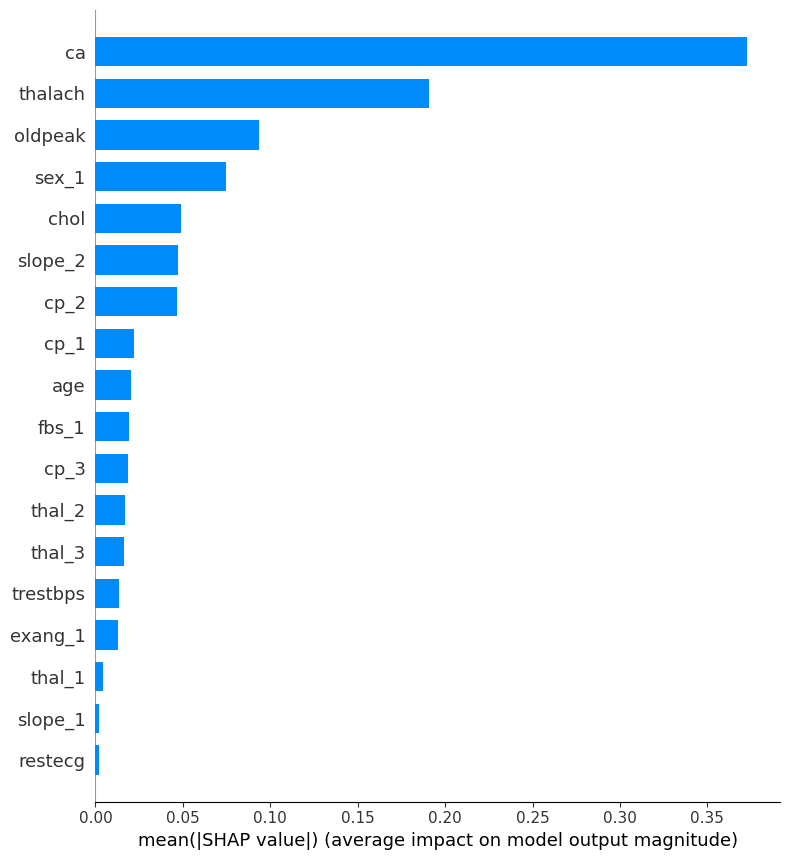

In [ ]:
posiciones_casos_etiqueta_objetivo=[]

for i, valor in enumerate(y):
  if valor == target:
    posiciones_casos_etiqueta_objetivo.append(i)

Fondo_Shap=X_scaled[posiciones_casos_etiqueta_objetivo]
explainer = shap.KernelExplainer(model, Fondo_Shap[:1000])
shap_values  = explainer.shap_values(instance)
print(shap_values.T)
nombres_columnas = X.columns.tolist()
shap.initjs()
shap.summary_plot(shap_values.T, instance.reshape(1,-1), plot_type="bar",feature_names=nombres_columnas)

In [ ]:
counterfactuals_df=createCounterfactual(data_counterfactual_Heart, instance, target,target_name, multiclass, model,density_test,n_neigbors_nbrs, density_threshold, num_counterfactuals, max_modificable_feature, inicial_learning_rate, factor_decay_learning, minimal_learning_rate, iterations, restriccion_categorias_no_modificables, restriccion_variables_categoricas)

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


In [ ]:
counterfactuals_df

,age,trestbps,chol,restecg,thalach,oldpeak,ca,sex_1,cp_1,cp_2,cp_3,fbs_1,exang_1,slope_1,slope_2,thal_1,thal_2,thal_3
0,0.839089,0.364848,0.919336,0.901657,-0.302966,0.739054,-0.714911,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.839089,0.364848,0.919336,0.901657,-0.954665,-0.470872,0.280034,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.839089,0.364848,0.495308,0.901657,-1.337401,-0.621586,0.280034,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.839089,0.364848,0.282926,0.901657,-1.287530,0.010830,0.280034,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


In [ ]:
data_counterfactual_instance = pd.DataFrame([instance], columns=X.columns)
data_counterfactual_instance

,age,trestbps,chol,restecg,thalach,oldpeak,ca,sex_1,cp_1,cp_2,cp_3,fbs_1,exang_1,slope_1,slope_2,thal_1,thal_2,thal_3
0,0.839089,0.364848,0.919336,0.901657,-1.905464,0.739054,2.269926,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


In [ ]:
variables_dummies=['sex_', 'cp_', 'fbs_','exang_','slope_','thal_']
columnas_no_binarias = [col for col in counterfactuals_df.columns if not any(col.startswith(prefix) for prefix in variables_dummies)]
counterfactuals = np.array(counterfactuals_df)

df_no_binarias = counterfactuals_df[columnas_no_binarias]
df_no_binarias_original = pd.DataFrame(scaler_Heart.inverse_transform(df_no_binarias), columns=columnas_no_binarias)

counterfactuals_df[columnas_no_binarias] = df_no_binarias_original

variables_dummies=['sex_', 'cp_', 'fbs_','exang_','slope_','thal_']
for dummy in variables_dummies:
    dummy_columns = [col for col in counterfactuals_df.columns if col.startswith(dummy)]
    new_val = [0] * len(counterfactuals)
    for cd, name_col in enumerate(dummy_columns):
        for i, val in enumerate(counterfactuals_df[name_col]):
            if val == 1:
                new_val[i] = cd+1
    counterfactuals_df[dummy[:-1]] = new_val
    counterfactuals_df.drop(dummy_columns, axis=1, inplace=True)


In [ ]:
variables_dummies=['sex_', 'cp_', 'fbs_','exang_','slope_','thal_']
columnas_no_binarias = [col for col in data_counterfactual_instance.columns if not any(col.startswith(prefix) for prefix in variables_dummies)]
instance_np = np.array(data_counterfactual_instance)

df_no_binarias = data_counterfactual_instance[columnas_no_binarias]
df_no_binarias_original = pd.DataFrame(scaler_Heart.inverse_transform(df_no_binarias), columns=columnas_no_binarias)

data_counterfactual_instance[columnas_no_binarias] = df_no_binarias_original

variables_dummies=['sex_', 'cp_', 'fbs_','exang_','slope_','thal_']
for dummy in variables_dummies:
    dummy_columns = [col for col in data_counterfactual_instance.columns if col.startswith(dummy)]
    new_val = [0] * len(instance_np)
    for cd, name_col in enumerate(dummy_columns):
        for i, val in enumerate(data_counterfactual_instance[name_col]):
            if val == 1:
                new_val[i] = cd+1
    data_counterfactual_instance[dummy[:-1]] = new_val
    data_counterfactual_instance.drop(dummy_columns, axis=1, inplace=True)

In [ ]:
data_X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
variables_dummies=['sex_', 'cp_', 'fbs_','exang_','slope_','thal_']
columnas_no_binarias = [col for col in data_X_scaled.columns if not any(col.startswith(prefix) for prefix in variables_dummies)]

df_no_binarias = data_X_scaled[columnas_no_binarias]
df_no_binarias_original = pd.DataFrame(scaler_Heart.inverse_transform(df_no_binarias), columns=columnas_no_binarias)
data_X_scaled[columnas_no_binarias] = df_no_binarias_original

for dummy in variables_dummies:
    dummy_columns = [col for col in data_X_scaled.columns if col.startswith(dummy)]
    new_val = [0] * len(np.array(data_X_scaled))
    for cd, name_col in enumerate(dummy_columns):
        for i, val in enumerate(data_X_scaled[name_col]):
            if val == 1:
                new_val[i] = cd+1
    data_X_scaled[dummy[:-1]] = new_val
    data_X_scaled.drop(dummy_columns, axis=1, inplace=True)


In [ ]:
counterfactuals_df

,age,trestbps,chol,restecg,thalach,oldpeak,ca,sex,cp,fbs,exang,slope,thal
0,62.0,138.0,294.000000,1.0,142.642055,1.900000,0.0,0,0,1,0,1,2
1,62.0,138.0,294.000000,1.0,127.740564,0.497057,1.0,0,0,1,0,1,2
2,62.0,138.0,272.091446,1.0,118.989102,0.322300,1.0,0,0,1,0,1,2
3,62.0,138.0,261.118160,1.0,120.129425,1.055604,1.0,0,2,1,0,1,2


In [ ]:
columnas_a_redondear = ['chol', 'thalach', 'oldpeak']
counterfactuals_df[columnas_a_redondear] = counterfactuals_df[columnas_a_redondear].round(1)

In [ ]:
counterfactuals_df

,age,trestbps,chol,restecg,thalach,oldpeak,ca,sex,cp,fbs,exang,slope,thal
0,62.0,138.0,294.0,1.0,142.6,1.9,0.0,0,0,1,0,1,2
1,62.0,138.0,294.0,1.0,127.7,0.5,1.0,0,0,1,0,1,2
2,62.0,138.0,272.1,1.0,119.0,0.3,1.0,0,0,1,0,1,2
3,62.0,138.0,261.1,1.0,120.1,1.1,1.0,0,2,1,0,1,2


In [ ]:
data_counterfactual_instance

,age,trestbps,chol,restecg,thalach,oldpeak,ca,sex,cp,fbs,exang,slope,thal
0,62.0,138.0,294.0,1.0,106.0,1.9,3.0,0,0,1,0,1,2


# Propuesta 2. Generador Incremental de Contrafactuales

In [ ]:
def shap_instace(X, instancia, model, posiciones_casos_etiqueta_objetivo):
  """
  Cálculo de los valores SHAP para una instancia dada a partir del modelo indicado y un conjunto de datos de fondo formado por 1000 muestras pertenecientes a la clase objetivo.
  Args:
    X: El conjunto de datos como una matriz bidimensional.
    instancia: La instancia sometida a estudio para la cual se calcularán los valores SHAP.
    model: El modelo predictivo utilizado para generar los valores SHAP.
    posiciones_casos_etiqueta_objetivo: Las posiciones de las muestras en el conjunto de datos utilizadas como fondo para el cálculo de SHAP.
  Returns:
    shap_values_instancia: Los valores SHAP para la instancia dada.
  """
  Fondo_Shap=X[posiciones_casos_etiqueta_objetivo]
  explainer = shap.KernelExplainer(model, Fondo_Shap[:1000])
  shap_values_instancia  = explainer.shap_values(instancia.reshape(1, -1))
  shap_values_abs = [[abs(numero) for numero in sublista] for sublista in shap_values_instancia]
  return shap_values_instancia

def create_neighbors_graph(X,y,distances, target, max_distance,density,min_density):
    """
    Desarrollo de un grafo sobre todas muestras del conjunto de datos estableciendo conexiones entre nodos que no superen una distancia máxima, que cumplan un mínimo de densidad y no unan dos nodos
    que pertenezcan a la clase objetivo
    Args:
      X: El conjunto de datos como una matriz bidimensional.
      y: Las etiquetas de las muestras.
      distances: La matriz de distancias entre las muestras.
      target: La etiqueta objetivo a conseguir en el contrafactual.
      max_distance: La distancia máxima permitida para considerar dos muestras como vecinos.
      density: La densidad de cada una de las muestras en el conjunto de datos.
      min_density: La densidad mínima requerida para considerar una muestra valida para ser incluida en el grafo.
    Returns:
      G: El grafo de vecinos creado.
    """
    G = nx.Graph()
    for i in range(len(X)):
        G.add_node(i)
    for i in range(len(X)):
      for j in range(i+1, len(X)):
        distance=distances[i, j]
        if not (y[i]==target and y[j]==target):
          if i==0 or density[i] > min_density:
            if distance <= max_distance and distance !=0 and density[j] > min_density:
              G.add_edge(i, j, weight=distance)
    return G

def dijkstra(graph, start):
    """
    Implementación del algoritmo de Dijkstra para encontrar las distancias y los caminos más cortos desde el nodo inicial hasta el caso contrafactual más cercano en el grafo formado.
    Args:
      graph: El grafo sobre el que se ejecutará el algoritmo.
      start: El nodo del caso original desde el cual se calcularán las distancias y los caminos más cortos.
    Returns:
      distances: Un diccionario que contiene las distancias más cortas desde el nodo de inicio a cada nodo en el grafo.
      shortest_paths: Un diccionario que contiene los caminos más cortos desde el nodo de inicio a cada nodo en el grafo.
    """
    distances = {node: float('infinity') for node in graph.nodes()}
    distances[start] = 0
    shortest_paths = {node: [] for node in graph.nodes()}
    priority_queue = [(0, start)]
    shortest_paths[start] = [start]
    while priority_queue:
        current_distance, current_node = heapq.heappop(priority_queue)
        if current_distance > distances[current_node]:
            continue
        for neighbor in graph.neighbors(current_node):
            weight = graph[current_node][neighbor]['weight']
            distance = current_distance + weight
            if distance < distances[neighbor] and distance !=0:
                distances[neighbor] = distance
                heapq.heappush(priority_queue, (distance, neighbor))
                shortest_paths[neighbor] = shortest_paths[current_node] + [neighbor]
        priority_queue.sort()
    return distances,shortest_paths

def crear_camino_desde_lista(lista_nodos):
  """
  Desarrollo de una lista de aristas a partir de una lista de nodos que representan un camino.
  Args:
    lista_nodos: La lista de nodos que representan un camino en el grafo.
   Returns:
    lista_nodos: La misma lista de nodos proporcionada como entrada.
    aristas_camino: Una lista de aristas que forman el camino representado por la lista de nodos.
  """
  aristas_camino = [(lista_nodos[i], lista_nodos[i + 1]) for i in range(len(lista_nodos) - 1)]  # Lista de aristas
  return lista_nodos, aristas_camino

def make_prediction(model,case_study,multiclass):
  """
  Predicción sobre la muestra utilizando el modelo de clasificación indicado por el usuario.
  Args:
    model: El modelo entrenado que se utilizará para la predicción.
    case_study: Un array que representa la muestra para la cual se realizará la predicción.
    multiclass: Un indicador de si el modelo es para un problema multiclase o binario.
  Returns:
    prediction: La clase predicha para el caso de estudio.
  """
  if multiclass:
    prediction=np.argmax(model.predict(case_study.reshape(1, -1)))
  else:
    prediction = round(model.predict(case_study.reshape(1, -1))[0][0])
  return prediction

def density_groupH(density_test,counterfactual,modelD,density_threshold,n_neighbors):
  """
  Determina si la densidad de una muestra cumple con el mínimo de densidad indicado.
  Args:
    density_test: Método para calcular la densidad, puede ser "nbrs" o "nbrs_mean".
    counterfactual: Counterfactual para el cual se evaluará la densidad.
    modelD: Modelo de densidad.
    density_threshold: Umbral de densidad que se debe superar para que la muestra sea valida.
    n_neighbors: Número de vecinos más cercanos para considerar en el cálculo de la densidad.
  Returns:
    bool: True si la densidad de la muestra es mayor o igual al umbral especificado, False de lo contrario.
  """
  distancias_nueva, _ = modelD.kneighbors(counterfactual)
  if density_test=="nbrs":
    distancia_k = distancias_nueva[0][n_neighbors-1]
    densidad_muestra = 1.0 / (distancia_k + 1e-6)
  else:
    densidad_muestra = 1.0 / (np.mean(distancias_nueva[:,1:], axis=1) + 1e-6)
  return densidad_muestra >= density_threshold

def chi2(posiciones_no_modificables, posiciones_mas_altas, X, variables_categoricas,grupos_dummy,causales_dummy):
  """
  Identificación de características categóricas relacionadas con las características seleccionadas para formar el contrafactual mediante la prueba de independencia chi-cuadrado.
  Args:
    posiciones_no_modificables: Una lista de las posiciones de características que no deben ser modificadas indicadas por parametro.
    posiciones_mas_altas: Una lista de las posiciones de las características seleccionadas según su importancia para formar el contrafactual.
    X: El conjunto de datos como una matriz bidimensional.
    variables_categoricas: Una lista de posiciones de las características categóricas en X.
    grupos_dummy: Un diccionario donde las claves son nombres de características y los valores son listas de posiciones de columnas dummy asociadas.
    causales_dummy: Una lista de posiciones de características dummy relacionadas con las características de las posiciones_mas_altas.
  Returns:
    posiciones_causales_chi2: Una lista de posiciones de características identificadas como relevantes mediante la prueba chi-cuadrado.
    restriciones_causales: Un diccionario que asigna posiciones de características más importantes a posiciones de características relevantes identificadas.
  """
  posiciones_no_causales=posiciones_no_modificables + posiciones_mas_altas + causales_dummy
  posibles_posiciones_causales = list(range(0, (X.shape[1])))
  caracteristicas_causalidad = [numero for numero in posibles_posiciones_causales if numero not in posiciones_no_causales]
  caracteristicas_causalidad_categoricas = [x for x in caracteristicas_causalidad if x in variables_categoricas]
  posiciones_causales=[]
  posiciones_causales_total=[]
  restriciones_causales={}
  for caracteristica_importante in posiciones_mas_altas:
    if len(set(X_scaled[:1000,caracteristica_importante]))>len(X_scaled[:1000,caracteristica_importante])*0.9:
      continue
    ipos = 0
    posiciones_causales=[]
    while ipos < len(caracteristicas_causalidad_categoricas):
        caracteristica_causal = caracteristicas_causalidad_categoricas[ipos]
        dummy=False
        caracteristica_compare=X[:1000,caracteristica_causal]
        for grupo, caracteristicas in grupos_dummy.items():
          if caracteristica_causal in caracteristicas:
            caracteristica_compare = np.where(np.all(X[:1000,caracteristicas] == 0, axis=1), 0, np.argmax(X[:1000,caracteristicas], axis=1)+1)
            ipos += len(caracteristicas)-1
            caracteristica_causal=caracteristicas
            dummy=True
            break
        tabla_de_frecuencia = pd.crosstab(X[:1000,caracteristica_importante], caracteristica_compare)
        chi2, _, _, _ = chi2_contingency(tabla_de_frecuencia)
        n = tabla_de_frecuencia.sum().sum()
        coef_contingencia = np.sqrt(chi2 / (n * min(tabla_de_frecuencia.shape) - 1))
        ipos += 1
        if coef_contingencia > 0.8:
          if dummy==True:
            posiciones_causales =posiciones_causales + caracteristica_causal
          else:
            posiciones_causales.append(caracteristica_causal)
    posiciones_causales_total=posiciones_causales_total+posiciones_causales
  posiciones_causales_chi2=list(set(posiciones_causales_total))
  return posiciones_causales_chi2

def dummies(posiciones_mas_altas, caracteristicas_columnas_dummies):
  """
  Indentificación de las posiciones de las características dummy ligadas con las características seleccionadas por su importancia para formar el contrafactual.
  Args:
    posiciones_mas_altas: Una lista de las posiciones de las características seleccionadas según su importancia para formar el contrafactual.
    caracteristicas_columnas_dummies: Un diccionario donde las claves son nombres de características y los valores son listas de posiciones de columnas dummy asociadas.
  Returns:
    posiciones_causales_dummies: Una lista de las posiciones de las características dummy relacionadas con las características más importantes.
  """
  resultados = []
  for val in posiciones_mas_altas:
    for sublist in caracteristicas_columnas_dummies.values():
      if val in sublist:
        resultados.extend(sublist)
        break
  posiciones_causales = list(set(resultados))
  posiciones_causales_dummies = [valor for valor in posiciones_causales if valor not in posiciones_mas_altas]
  return posiciones_causales_dummies

def make_model_density(test_density,n_neighbors,X_train,X):
  """
  Desarrollo del modelo de densidad basado en los datos y calculo la densidad general.
  Args:
    test_density: Método para calcular la densidad, puede ser "nbrs" o "nbrs_mean".
    n_neighbors: Número de vecinos más cercanos para considerar en el cálculo de la densidad.
    X_train: Datos utilizados para ajustar el modelo de densidad.
    X: Datos para los cuales se calculará la densidad.
  Returns:
    density: Densidad calculada para los datos proporcionados.
    model_density: Modelo de densidad.
  """
  model_density = NearestNeighbors(n_neighbors=n_neighbors)
  model_density.fit(X_train)
  distancias_nueva, _ = model_density.kneighbors(X)
  if test_density=="nbrs":
      density = 1.0 / (distancias_nueva[:,n_neighbors-1] + 1e-6)
  else:
      density = 1.0 / (np.mean(distancias_nueva[:,1:], axis=1) + 1e-6)
  return density, model_density

def gower_precentile(X):
  """
  Cálculo de los rangos intercuartílicos (IQR) para la normalización posterior de las muestras.
  Args:
    X: Una matriz bidimensional donde cada columna representa una variable y cada fila una muestra.
  Return:
    ranges: Una lista de los rangos especificos calculados sobre cada caracteristica.
  """
  ranges=[]
  percentiles_base = [(80, 20),(85,15), (90, 10), (95, 5)]
  percentiles_exception= [(95.1 + i * 0.1, 4.9 - i * 0.1) for i in range(0, 50)]
  percentiles=percentiles_base+percentiles_exception
  for z,column in enumerate(X.T):
    elementos_unicos = set(column)
    if elementos_unicos == {0, 1}:
      rang = 1
    else:
      for p_high, p_low in percentiles:
        rang = np.percentile(column, p_high) - np.percentile(column, p_low)
        if rang != 0:
          break
        else:
          rang=1
    ranges.append(rang)
  return ranges

def transform_data(X, rangos_normalizacion):
    """
    Normalización de las muestras en la matriz X utilizando los rangos dados.
    Args:
      X: Una matriz bidimensional donde cada columna representa una variable y cada fila una muestra.
      rangos_normalizacion: Una lista de los rangos de normalización correspondientes a cada característica en X.
    Returns:
      np.array(X_norm): Una matriz bidimensional de muestras normalizadas.
    """
    X_norm = X.copy()
    X_norm /= rangos_normalizacion
    return np.array(X_norm)

In [ ]:
def contrafactuales_incrementales(data,instance,multiclass,target,target_name,model,distance_threshold=1,test_density="nbrs_mean",n_neighbors=20,density_threshold=0,density_on_target=False,instanceChanges=False,restriccion_características_no_modificables=[],restriccion_variables_categoricas=[]):
  """
  Función principal para construir un camino incremental de muestras para una instancia hacia una situación contrafactual
  Args:
    data: DataFrame que contiene el conjunto de datos.
    instance: La instancia de datos para la cual se generarán el camino.
    multiclass: Indica si el problema es de clasificación multiclase o no.
    target: La etiqueta objetivo para el cual se llegara al contrafactual.
    model: El modelo predictivo utilizado para la clasificación.
    distance_threshold: Umbral de distancia para considerar la cercanía de las instancias. Un valor de 0 a 10 correspondiendose el 10 a la máxima distancia entre muestras.
    test_density: Método de cálculo de la densidad, puede ser "nbrs_mean" o "nbrs".
    n_neighbors: Número de vecinos más cercanos para considerar en el cálculo de la densidad.
    density_threshold: Umbral de densidad mínima como un valor de 0 a 1 siendo uno el valor máximo observado en el conjunto.
    density_on_target: Indica si se evalúa la densidad basada en el objetivo para el contrafactual.
    instanceChanges: Indica si se quiere cambiar la instancia original.
    restriccion_características_no_modificables: Restricción como lista de características que no se pueden modificar en la instancia.
    restriccion_variables_categoricas: Restricción como lista de variables categóricas.
  Returns:
    counterfactuals: DataFrame con el camino de muestras obtenido.
    nodos_camino: Lista de nodos en el camino hacia el contrafactual.
    sustitution_counterfactuals: DataFrame con los casos formados por sustitución generados.
  """
  # Preparado de los datos y los rangos de normalización
  nodos_camino=[]
  if test_density!="nbrs" and test_density!="nbrs_mean":
    print("No se ha indicado una forma disponibles al medir la densidad (test_density): nbrs o nbrs_mean ")
    return counterfactuals, nodos_camino, sustitution_counterfactuals
  columns_name=data.columns
  y = data[target_name]
  data.drop([target_name], axis=1, inplace=True)
  X=data
  counterfactuals = pd.DataFrame()
  counterfactuals = pd.DataFrame(columns=data.columns)
  sustitution_counterfactuals = pd.DataFrame()
  sustitution_counterfactuals = pd.DataFrame(columns=data.columns)
  X = np.array(X)
  y = np.array(y)
  rangos_normalizacion = gower_precentile(X)

  # Identificación de las posiciones de las muestras con la etiqueta objetivo
  posiciones_casos_etiqueta_objetivo=[]
  for i, valor in enumerate(y):
    if valor == target:
      posiciones_casos_etiqueta_objetivo.append(i)

  # Cálculo de los valores SHAP para la instancia dada
  shap_values_instancia=shap_instace(X, instance, model, posiciones_casos_etiqueta_objetivo)

  # Desarrollo del vector de pesos SHAP y de una lista ordenada con las variables de mayor contribución
  if multiclass==True:
    shap_elements = [sublist[target] for sublist in shap_values_instancia[0]]
    weights_shap=np.abs(shap_elements)
    valores_con_indices = list(enumerate(abs(np.array(shap_elements))))
  else:
    weights_shap=shap_values_instancia[0]
    weights_shap=np.abs(weights_shap)
    valores_con_indices = list(enumerate(abs(shap_values_instancia[0])))
  weights=weights_shap.flatten()

  # Identificación de las posiciones de características no modificables
  posiciones_no_modificables = [c for c, columna in enumerate(columns_name) if any(columna.startswith(restriccion+'_') or columna == restriccion for restriccion in restriccion_características_no_modificables)]

  # Normalización y representación de los datos y la instancia de estudio
  X_norm=transform_data(X,rangos_normalizacion)
  instance_norm=transform_data(instance.reshape(1, -1),rangos_normalizacion)
  X_representative_original = np.vstack([instance, X])
  X_representative = np.vstack([instance_norm[0], X_norm])
  y_representative = np.hstack([np.ones(1)*make_prediction(model,instance,multiclass),y])

  # Calculo de las distancias ponderadas y la densidad
  weights[posiciones_no_modificables]= 1
  X_weighted=X_representative*(-1*(weights-1))
  distances = pdist(X_weighted, metric='euclidean')
  distances_reescalado_square = squareform(distances)
  density,model_density=make_model_density(test_density,n_neighbors,X_norm,X_representative)

  # Calculo de la máxima distancias entre muestras y la mínima densidad permitida en el grafo
  min_density = np.percentile(density, density_threshold*100)
  max_distance = np.percentile(distances, distance_threshold*10)

  # Desarrollo del grafo basado en las muestras del conjunto de datos y aplicación del algoritmo de Dijkstra para encontrar las distancias más cortas desde el nodo inicial hasta todos los demás nodos en el grafo
  neighbors_graph = create_neighbors_graph(X_representative,y_representative,distances_reescalado_square,target,max_distance,density,min_density)
  shortest_distances, shortest_paths = dijkstra(neighbors_graph, 0)

  # Filtro sobre los caminos formados para considerar unicamente los que lleguen a un escenario contrafactual y se ordenan de menor a mayor distancia
  for node, distance in list(shortest_distances.items()):
    if y_representative[node]!=target:
      del shortest_distances[node]
  sorted_distances = sorted(shortest_distances.items(), key=lambda x: x[1])

  # Cálculo la densidad basada en el objetivo (opcional) y comprobación de clase
  if density_on_target==True:
    density_target,model_density_target=make_model_density(test_density,n_neighbors,X_norm[y==target],X_representative[y_representative==target])
    min_density_target = np.percentile(density_target, density_threshold*100)
  for node, distance in sorted_distances:
    if density_on_target==True and density_groupH(test_density,[X_representative[node]],model_density_target,min_density_target,n_neighbors)==False:
      continue
    caso_contrafactual_camino_mas_cercano=X_representative_original[node].copy()
    pred=make_prediction(model,caso_contrafactual_camino_mas_cercano,multiclass)
    if pred==target:
      break

  # Desarrollo de camino hacia el nodo encontrado y se almacena como DataFrames
  nodos_camino, aristas_camino = crear_camino_desde_lista(shortest_paths[node])
  if nodos_camino==[]:
    print("No se ha encontrado un camino de casos para conseguir un contrafactual real. Prueba ha modificar parametros como aumentar el umbrales de distancia y densidad de muestra")
    return  counterfactuals, nodos_camino, sustitution_counterfactuals
  for node in nodos_camino:
    counterfactuals.loc[len(counterfactuals)] = X_representative_original[node]

  if instanceChanges==True:

    path_original_nodes=X_representative_original[nodos_camino]
    path_nodes=X_representative[nodos_camino]

    # Se ordenan las características por importancia, se filtra las características modificables y se identifican las posiciones de las variables categóricas para manejarlas adecuadamente (variables dummies)
    valores_con_indices.sort(key=lambda x: x[1], reverse=True)
    valores_con_indices_filtrados = [(indice, valor) for indice, valor in valores_con_indices]
    indice_actual_posalta= 0
    posiciones_mas_altas = []
    posiciones_causales_combinadas=[]
    posiciones_variables_categoricas=[]
    caracteristicas_columnas_dummies = {restriccion: [] for restriccion in restriccion_variables_categoricas}
    for i, columna in enumerate(columns_name):
      for restriccion in restriccion_variables_categoricas:
        if columna.startswith(restriccion):
          posiciones_variables_categoricas.append(i)
          if columna.startswith(restriccion+"_"):
            caracteristicas_columnas_dummies[restriccion].append(i)

    # Bucle principal para formar el camino por sustitución sobre la instancia original
    while True:
      while True:
        if indice_actual_posalta >= len(valores_con_indices_filtrados):
          print("No es posible formar un contrafactual a partir del camino mas corto considerando solo las carasteristicas no restringidas")
          return counterfactuals, nodos_camino, sustitution_counterfactuals
        indice, valor = valores_con_indices_filtrados[indice_actual_posalta]
        if indice not in posiciones_causales_combinadas and indice not in posiciones_no_modificables:
            posiciones_mas_altas.append(indice)
            indice_actual_posalta += 1
            break
        indice_actual_posalta += 1
      # Conclusión sobre las posiciones de las características consideradas causales con una relación directa con el conjunto a modificar seleccionado (dummies y combinadas)
      posiciones_causales_dummies=dummies(posiciones_mas_altas,caracteristicas_columnas_dummies)
      posiciones_causales_chi2=chi2(posiciones_no_modificables, posiciones_mas_altas, X, posiciones_variables_categoricas,caracteristicas_columnas_dummies,posiciones_causales_dummies)
      posiciones_causales_combinadas = posiciones_causales_chi2 + posiciones_causales_dummies
      posiciones_causales_combinadas = list(set(posiciones_causales_combinadas))
      new_path_based = []
      first_node=True
      good_path = True
      # Comprobación sobre si las nuevas muestras cumplen con las restricciones de densidad y alcanzan el objetivo
      for case_study_original, case_study_norm in zip(path_original_nodes,path_nodes):
        original_node = path_original_nodes[0].copy()
        norm_node = path_nodes[0].copy()
        for t in posiciones_mas_altas:
          original_node[t] = case_study_original[t]
          norm_node[t] = case_study_norm[t]
        for i in posiciones_causales_combinadas:
          original_node[i] = case_study_original[i]
          norm_node[t] = case_study_norm[t]
        if density_groupH(test_density,norm_node.reshape(1, -1), model_density,min_density,n_neighbors)==True or first_node==True:
            first_node=False
            new_path_based.append(original_node)
        else:
            good_path = False
            break
      if good_path == True and make_prediction(model,new_path_based[-1],multiclass)==target:
        for node in new_path_based:
          sustitution_counterfactuals.loc[len(sustitution_counterfactuals)] = node
        break

  return counterfactuals, nodos_camino, sustitution_counterfactuals


## Ejemplo de prueba de la propuesta 2

In [ ]:
def scalerTest(X,standar_object):

    boolean_cols = [col for col in X.columns if set(X[col].unique()) == {0, 1} or set(X[col].unique()) == {0} or set(X[col].unique()) == {1}]
    X_boolean = X[boolean_cols].astype(int)

    non_boolean_columns = [col for col in X.columns if X[col].dtype != bool]
    X_non_boolean = X[non_boolean_columns]
    X_non_boolean_scaled = standar_object.fit_transform(X_non_boolean)

    X_scaled = X.copy()
    X_scaled[non_boolean_columns] = X_non_boolean_scaled

    X_scaled[X_boolean.columns] = X_boolean

    return np.array(X_scaled)

def scaler(X_train, X_normalTest, X_finalTest):
    boolean_features = [col for col in X_train.columns if X_train[col].dtype == bool]

    non_boolean_features = [col for col in X_train.columns if col not in boolean_features]
    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_normalTest_scaled = X_normalTest.copy()
    X_finalTest_scaled = X_finalTest.copy()

    X_train_scaled[non_boolean_features] = scaler.fit_transform(X_train[non_boolean_features])
    X_normalTest_scaled[non_boolean_features] = scaler.transform(X_normalTest[non_boolean_features])
    X_finalTest_scaled[non_boolean_features] = scaler.transform(X_finalTest[non_boolean_features])

    for feature in boolean_features:
        X_train_scaled[feature] = X_train[feature].astype(int)
        X_normalTest_scaled[feature] = X_normalTest[feature].astype(int)
        X_finalTest_scaled[feature] = X_finalTest[feature].astype(int)

    return scaler, X_train_scaled, X_normalTest_scaled, X_finalTest_scaled

In [ ]:
dataHeart = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TFM/Data/dataHeart_procesed.csv')
data = dataHeart.copy()
y = data['target']
data.drop(['target'], axis=1, inplace=True)
x=data

columnas_ordenadas=x.columns

X_train_Heart, X_test, y_train_Heart, y_test = train_test_split(x, y, test_size=0.2, random_state=16)
X_normalTest_Heart, X_finalTest_Heart, y_normalTest_Heart, y_finalTest_Heart = train_test_split(X_test, y_test, test_size=0.5, random_state=16)
scaler_Heart, X_trainScaled_Heart, X_normalTestScaled_Heart, X_finalTestScaled_Heart=scaler(X_train_Heart,X_normalTest_Heart,X_finalTest_Heart)
Heart_model = load_model('/content/drive/MyDrive/Colab Notebooks/TFM/Modelos/Heart_model.h5')


In [ ]:
data = dataHeart.copy()
target_name="target"

y = data[target_name]
data.drop([target_name], axis=1, inplace=True)
X = data
X_scaled = scalerTest(X,scaler_Heart)
y = np.array(y)

data_counterfactual_Heart = pd.DataFrame(X_scaled, columns=X.columns)
data_counterfactual_Heart['target'] = y

restriccion_variables_categoricas = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
restriccion_categorias_no_modificables=[]

target=1
multiclass=False
instance=X_scaled[78]
model=Heart_model

print(instance)
print(y[78])
prediction = round(model.predict(instance.reshape(1, -1))[0][0])
print(prediction)


[ 1.50332164  0.70703461 -1.0354625   0.90165655 -0.37477894  2.0326841
  1.27497996  1.          0.          0.          0.          1.
  0.          1.          0.          0.          0.          1.        ]
0
1/1 [==============================] - 0s 74ms/step
0


[[ 0.03673531 -0.02595771  0.04551395 -0.00054011 -0.059139   -0.20428633
  -0.20010957 -0.06739661 -0.01932331 -0.04291398 -0.01793446  0.02342711
   0.01166852 -0.00171035 -0.05199336 -0.0074277  -0.06605493 -0.10413504]]


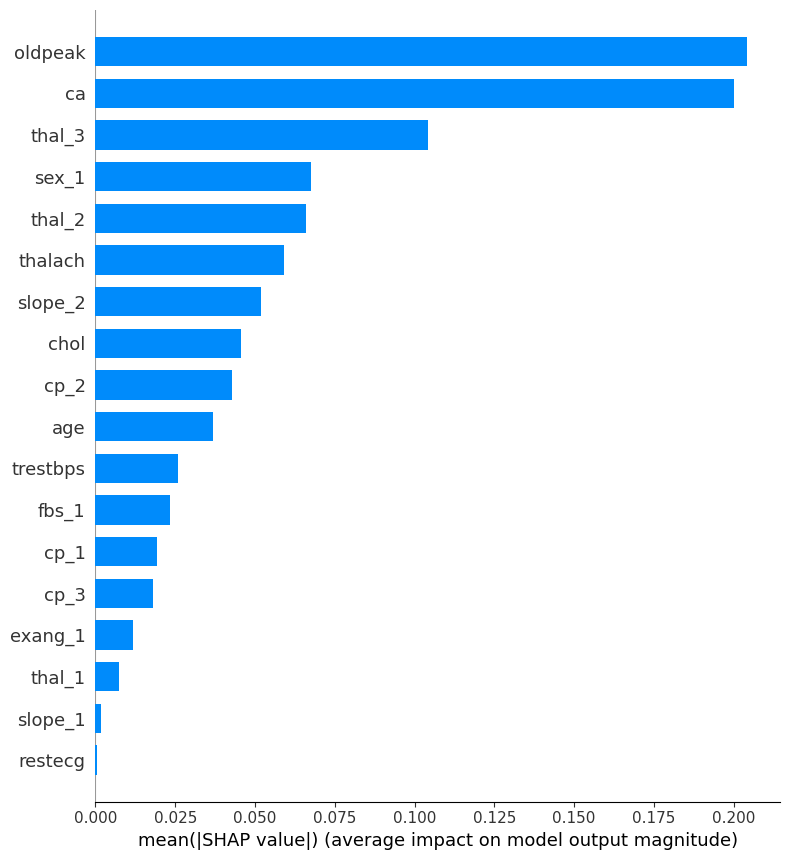

In [ ]:
posiciones_casos_etiqueta_objetivo=[]

for i, valor in enumerate(y):
  if valor == target:
    posiciones_casos_etiqueta_objetivo.append(i)

Fondo_Shap=X_scaled[posiciones_casos_etiqueta_objetivo]
explainer = shap.KernelExplainer(model, Fondo_Shap[:1000])
shap_values  = explainer.shap_values(instance)
print(shap_values.T)
nombres_columnas = X.columns.tolist()
shap.initjs()
shap.summary_plot(shap_values.T, instance.reshape(1,-1), plot_type="bar",feature_names=nombres_columnas)

In [ ]:
distance_threshold=0.3
test_density="nbrs_mean"
n_neighbors=5
density_threshold=0.25
density_on_target=False
counterfactuals, nodos_camino,sustitution_counterfactuals =contrafactuales_incrementales(data_counterfactual_Heart,instance,multiclass,target,target_name,model,distance_threshold,test_density,n_neighbors,density_threshold,density_on_target,True,restriccion_categorias_no_modificables,restriccion_variables_categoricas)


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


In [ ]:
counterfactuals

,age,trestbps,chol,restecg,thalach,oldpeak,ca,sex_1,cp_1,cp_2,cp_3,fbs_1,exang_1,slope_1,slope_2,thal_1,thal_2,thal_3
0,1.503322,0.707035,-1.035462,0.901657,-0.374779,2.032684,1.274980,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.396267,0.821097,-0.551602,0.901657,-1.949198,0.825296,0.280034,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.949794,-0.091401,0.145158,-1.002541,-0.112376,0.307844,0.280034,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,-0.046555,-0.661712,0.222576,-1.002541,-0.112376,-0.554576,-0.714911,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [ ]:
variables_dummies=['sex_', 'cp_', 'fbs_','exang_','slope_','thal_']
columnas_no_binarias = [col for col in counterfactuals.columns if not any(col.startswith(prefix) for prefix in variables_dummies)]

df_no_binarias = counterfactuals[columnas_no_binarias]
df_no_binarias_original = pd.DataFrame(scaler_Heart.inverse_transform(df_no_binarias), columns=columnas_no_binarias)

counterfactuals[columnas_no_binarias] = df_no_binarias_original

import pandas as pd

variables_dummies=['sex_', 'cp_', 'fbs_','exang_','slope_','thal_']
for dummy in variables_dummies:
    dummy_columns = [col for col in counterfactuals.columns if col.startswith(dummy)]
    new_val = [0] * len(counterfactuals)
    for cd, name_col in enumerate(dummy_columns):
        for i, val in enumerate(counterfactuals[name_col]):
            if val == 1:
                new_val[i] = cd+1
    counterfactuals[dummy[:-1]] = new_val
    counterfactuals.drop(dummy_columns, axis=1, inplace=True)


In [ ]:
counterfactuals

,age,trestbps,chol,restecg,thalach,oldpeak,ca,sex,cp,fbs,exang,slope,thal
0,68.0,144.0,193.0,1.0,141.0,3.4,2.0,1,0,1,0,1,3
1,58.0,146.0,218.0,1.0,105.0,2.0,1.0,1,0,0,0,1,3
2,63.0,130.0,254.0,0.0,147.0,1.4,1.0,1,0,0,0,1,3
3,54.0,120.0,258.0,0.0,147.0,0.4,0.0,1,2,0,0,1,3


In [ ]:
sustitution_counterfactuals

,age,trestbps,chol,restecg,thalach,oldpeak,ca,sex_1,cp_1,cp_2,cp_3,fbs_1,exang_1,slope_1,slope_2,thal_1,thal_2,thal_3
0,1.503322,0.707035,-1.035462,0.901657,-0.374779,2.032684,1.274980,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1.503322,0.707035,-0.551602,0.901657,-1.949198,0.825296,0.280034,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1.503322,0.707035,0.145158,0.901657,-0.112376,0.307844,0.280034,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1.503322,0.707035,0.222576,0.901657,-0.112376,-0.554576,-0.714911,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [ ]:
variables_dummies=['sex_', 'cp_', 'fbs_','exang_','slope_','thal_']
columnas_no_binarias = [col for col in sustitution_counterfactuals.columns if not any(col.startswith(prefix) for prefix in variables_dummies)]

df_no_binarias = sustitution_counterfactuals[columnas_no_binarias]
df_no_binarias_original = pd.DataFrame(scaler_Heart.inverse_transform(df_no_binarias), columns=columnas_no_binarias)

sustitution_counterfactuals[columnas_no_binarias] = df_no_binarias_original

variables_dummies=['sex_', 'cp_', 'fbs_','exang_','slope_','thal_']
for dummy in variables_dummies:
    dummy_columns = [col for col in sustitution_counterfactuals.columns if col.startswith(dummy)]
    new_val = [0] * len(counterfactuals)
    for cd, name_col in enumerate(dummy_columns):
        for i, val in enumerate(sustitution_counterfactuals[name_col]):
            if val == 1:
                new_val[i] = cd+1
    sustitution_counterfactuals[dummy[:-1]] = new_val
    sustitution_counterfactuals.drop(dummy_columns, axis=1, inplace=True)



In [ ]:
sustitution_counterfactuals

,age,trestbps,chol,restecg,thalach,oldpeak,ca,sex,cp,fbs,exang,slope,thal
0,68.0,144.0,193.0,1.0,141.0,3.4,2.0,1,0,1,0,1,3
1,68.0,144.0,218.0,1.0,105.0,2.0,1.0,1,0,1,0,1,3
2,68.0,144.0,254.0,1.0,147.0,1.4,1.0,1,0,1,0,1,3
3,68.0,144.0,258.0,1.0,147.0,0.4,0.0,1,2,1,0,1,3
